---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
import Stemmer 
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

load_dotenv()

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [3]:
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [4]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [6]:
products = load_wands_products(data_dir="./data")
queries = load_wands_queries(data_dir="./data")
labels = load_wands_labels(data_dir="./data")

print(f"Products: {len(products)} rows")
print(f"Queries: {len(queries)} rows")
print(f"Labels: {len(labels)} rows")

Products: 42994 rows
Queries: 480 rows
Labels: 233448 rows


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [ ]:
print("Available columns:")
print(products.columns.tolist())

Available columns:
['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count']


In [8]:
products.head()

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [9]:
print("Useful search fields:")
print("1. product_name - main title")
print("2. product_description - detailed text")
print("3. product_class - product category")
print("4. category_hierarchy - full category path")

Useful search fields:
1. product_name - main title
2. product_description - detailed text
3. product_class - product category
4. category_hierarchy - full category path


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [10]:
# Task 2c: Understand judgments

print("Grade distribution:")
print(labels['grade'].value_counts().sort_index(ascending=False))
print("\nLabel distribution:")
print(labels['label'].value_counts())


Grade distribution:
grade
2     25614
1    146633
0     61201
Name: count, dtype: int64

Label distribution:
label
Partial       146633
Irrelevant     61201
Exact          25614
Name: count, dtype: int64


---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [11]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [12]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [13]:
# Task 3a: Implement tokenizer

def tokenize(text: str) -> list[str]:
    """
    Tokenize text by:
    1. Converting to lowercase
    2. Removing punctuation
    3. Splitting on whitespace
    """
    if pd.isna(text):  # Handle missing values
        return []
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split on whitespace
    tokens = text.split()
    
    return tokens

# Test it
print(tokenize("Hello, World! This is a TEST."))
print(tokenize("Star Wars Rug"))

['hello', 'world', 'this', 'is', 'a', 'test']
['star', 'wars', 'rug']


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [14]:
# Task 3b: Implement build_index

def build_index(documents: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        documents: List of document strings
        tokenizer: Function to tokenize text
        
    Returns:
        index: dict mapping {term: {doc_id: count}}
        doc_lengths: list of document lengths (number of tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(documents):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        
        # Count tokens in this document
        token_counts = Counter(tokens)
        
        # Add to inverted index
        for token, count in token_counts.items():
            if token not in index:
                index[token] = {}
            index[token][doc_id] = count
    
    return index, doc_lengths

# Test it
test_docs = [
    "red leather sofa",
    "blue leather chair", 
    "red wooden chair"
]

test_index, test_lengths = build_index(test_docs, tokenize)

print("Index:", test_index)
print("Doc lengths:", test_lengths)
print("\nDocuments containing 'leather':", test_index.get('leather', {}))
print("Documents containing 'red':", test_index.get('red', {}))

Index: {'red': {0: 1, 2: 1}, 'leather': {0: 1, 1: 1}, 'sofa': {0: 1}, 'blue': {1: 1}, 'chair': {1: 1, 2: 1}, 'wooden': {2: 1}}
Doc lengths: [3, 3, 3]

Documents containing 'leather': {0: 1, 1: 1}
Documents containing 'red': {0: 1, 2: 1}


In [16]:


# Build index on product_name field
product_name_index, product_name_lengths = build_index(
    products['product_name'].tolist(), 
    tokenize
)

print(f"Indexed {len(products)} products")
print(f"Unique terms in index: {len(product_name_index)}")
print(f"Average product name length: {np.mean(product_name_lengths):.2f} tokens")

Indexed 42994 products
Unique terms in index: 29617
Average product name length: 6.27 tokens


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [17]:
# Task 4a: Implement helper functions

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """Get term frequency (count) for a term in a document."""
    if term not in index:
        return 0
    return index[term].get(doc_id, 0)

def get_df(term: str, index: dict) -> int:
    """Get document frequency (number of docs containing term)."""
    if term not in index:
        return 0
    return len(index[term])

def bm25_idf(df: int, num_docs: int) -> float:
    """
    Calculate BM25 IDF score.
    Formula: log((num_docs - df + 0.5) / (df + 0.5))
    """
    if df == 0:
        return 0.0
    return np.log((num_docs - df + 0.5) / (df + 0.5))

# Test the functions
print(f"TF of 'coffee' in doc 0: {get_tf('coffee', 0, product_name_index)}")
print(f"DF of 'coffee': {get_df('coffee', product_name_index)}")
print(f"IDF of 'coffee': {bm25_idf(get_df('coffee', product_name_index), len(products)):.4f}")

TF of 'coffee' in doc 0: 0
DF of 'coffee': 1585
IDF of 'coffee': 3.2626


### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [19]:
# Task 4b: Implement BM25 scoring

def score_bm25(query: str, index: dict, doc_lengths: list[int], 
               num_docs: int, tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Calculate BM25 scores for all documents given a query.
    
    Args:
        query: Search query string
        index: Inverted index
        doc_lengths: List of document lengths
        num_docs: Total number of documents
        tokenizer: Tokenization function
        k1: Term frequency saturation parameter (default 1.2)
        b: Length normalization parameter (default 0.75)
        
    Returns:
        Array of BM25 scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    
    # Calculate average document length
    avg_doc_len = np.mean(doc_lengths)
    
    # For each query term
    for term in query_tokens:
        df = get_df(term, index)
        if df == 0:
            continue  # Skip terms not in index
        
        # Calculate IDF for this term
        idf = bm25_idf(df, num_docs)
        
        # Calculate score contribution for each document
        for doc_id in range(num_docs):
            tf = get_tf(term, doc_id, index)
            if tf > 0:
                # Length normalization
                doc_len = doc_lengths[doc_id]
                norm = 1 - b + b * (doc_len / avg_doc_len)
                
                # BM25 formula: IDF * (TF * (k1 + 1)) / (TF + k1 * norm)
                tf_component = (tf * (k1 + 1)) / (tf + k1 * norm)
                scores[doc_id] += idf * tf_component
    
    return scores

# Test it
test_query = "coffee table"
test_scores = score_bm25(test_query, product_name_index, product_name_lengths, 
                         len(products), tokenize)

print(f"Query: '{test_query}'")
print(f"Number of products with score > 0: {np.sum(test_scores > 0)}")
print(f"Max score: {test_scores.max():.4f}")
print(f"Top 3 doc IDs: {np.argsort(test_scores)[-3:][::-1]}")

Query: 'coffee table'
Number of products with score > 0: 4446
Max score: 7.5715
Top 3 doc IDs: [20513 33290   608]


### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [20]:
# Task 4c: Create search function

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                   doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top k results.
    
    Args:
        query: Search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top k products and their scores
    """
    # Get BM25 scores
    scores = score_bm25(query, index, doc_lengths, len(products_df), tokenizer)
    
    # Get top k indices (sorted by score, descending)
    top_k_indices = np.argsort(scores)[-k:][::-1]
    
    # Create results dataframe
    results = products_df.iloc[top_k_indices].copy()
    results['score'] = scores[top_k_indices]
    
    # Filter out zero scores
    results = results[results['score'] > 0]
    
    return results[['product_name', 'product_class', 'score']]

# Test it
results = search_products("coffee table", products, product_name_index, 
                         product_name_lengths, tokenize, k=10)

print(f"Search results for 'coffee table':")
print(results)

Search results for 'coffee table':
                                       product_name             product_class  \
20513                                  coffee table  Coffee & Cocktail Tables   
33290                                  coffee table  Coffee & Cocktail Tables   
608                                    coffee table  Coffee & Cocktail Tables   
5173                                   coffee table              Patio Tables   
22679                                  coffee table  Coffee & Cocktail Tables   
19750  a-37 coffee table in , matching coffee table  Coffee & Cocktail Tables   
30371                          sanibel coffee table  Coffee & Cocktail Tables   
27518                       manzanillo coffee table                End Tables   
8082                            dortch coffee table  Coffee & Cocktail Tables   
24726                        clintwood coffee table  Coffee & Cocktail Tables   

          score  
20513  7.571510  
33290  7.571510  
608    7.571510  
5

In [22]:
# Task 4d: Test search on sample queries

test_queries = [
    "wooden bed frame",
    "leather sofa",
    "outdoor patio furniture",
    "kids bedroom set"
]

for query in test_queries:
    print(f"\n{'='*60}")
    print(f"Query: '{query}'")
    print('='*60)
    results = search_products(query, products, product_name_index, 
                             product_name_lengths, tokenize, k=5)
    print(results.to_string(index=False))


Query: 'wooden bed frame'
                      product_name product_class     score
mcdonell wooden frame platform bed          Beds 13.849290
    wooden window frame wall décor    Wall Décor 10.615593
                         bed frame          Beds 10.396858
                         bed frame    Bed Frames 10.396858
                         bed frame    Bed Frames 10.396858

Query: 'leather sofa'
                                product_name                     product_class    score
            chafin contemporary leather sofa Reception Sofas & Loveseats|Sofas 9.261937
     124 '' wide leather match sofa & chaise                        Sectionals 8.031607
          85 '' faux leather square arm sofa                             Sofas 8.031607
          85 '' faux leather tuxedo arm sofa Reception Sofas & Loveseats|Sofas 8.031607
hardee 86 '' genuine leather tuxedo arm sofa Reception Sofas & Loveseats|Sofas 7.531383

Query: 'outdoor patio furniture'
                                 p

---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [29]:
# Evaluation functions (provided)

def ndcg_at_k(relevance_scores: list, k: int) -> float:
    """
    Calculate NDCG@k (Normalized Discounted Cumulative Gain).
    
    Args:
        relevance_scores: List of relevance grades for results (in ranked order)
        k: Number of results to consider
        
    Returns:
        NDCG@k score between 0 and 1
    """
    # DCG: sum of (relevance / log2(position + 1))
    dcg = sum((rel / np.log2(i + 2)) for i, rel in enumerate(relevance_scores[:k]))
    
    # IDCG: DCG of perfect ranking
    ideal_scores = sorted(relevance_scores, reverse=True)
    idcg = sum((rel / np.log2(i + 2)) for i, rel in enumerate(ideal_scores[:k]))
    
    # NDCG
    if idcg == 0:
        return 0.0
    return dcg / idcg


def evaluate_single_query(query: str, query_id: int, products_df: pd.DataFrame, 
                         labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate a single query using NDCG@k.
    """
    # Get search results
    results = search_func(query, products_df, k=k)
    
    if len(results) == 0:
        return 0.0
    
    # Get ground truth labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    
    # Map product_id to relevance grade
    relevance_map = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Get product IDs from results (results.index contains the original product indices)
    result_product_ids = products_df.loc[results.index, 'product_id'].tolist()
    
    # Get relevance scores
    relevance_scores = [relevance_map.get(pid, 0) for pid in result_product_ids]
    
    # Calculate NDCG
    return ndcg_at_k(relevance_scores, k)


def evaluate_queries(queries_df, products_df, labels_df, search_func, k=10, verbose=False):
    """
    Evaluate search function on all queries.
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [30]:
# Task 5a: Run evaluation on all queries

# Create a search function wrapper for evaluation
def search_func(query: str, products_df: pd.DataFrame, k: int = 10) -> pd.DataFrame:
    """Wrapper function for evaluation."""
    return search_products(query, products_df, product_name_index, 
                          product_name_lengths, tokenize, k=k)

# Evaluate on all queries
baseline_results = evaluate_queries(
    queries, 
    products, 
    labels, 
    search_func, 
    k=10, 
    verbose=True
)

# Show some results
print("\nSample results:")
print(baseline_results.head(10))

Evaluated 480 queries
Mean NDCG@10: 0.8533

Sample results:
   query_id                      query      ndcg
0         0                salon chair  0.959831
1         1         smart coffee table  0.959856
2         2                   dinosaur  0.892458
3         3          turquoise pillows  0.796384
4         4  chair and a half recliner  1.000000
5         5          sofa with ottoman  0.976025
6         6        acrylic clear chair  0.524344
7         7           driftwood mirror  1.000000
8         8       home sweet home sign  1.000000
9         9      coffee table fire pit  1.000000


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [32]:
# Task 5b: Identify failing queries

# Find queries with low NDCG scores
failing_queries = baseline_results[baseline_results['ndcg'] == 0].sort_values('ndcg')

print(f"Number of queries with NDCG = 0: {len(failing_queries)}")
print("\nSample failing queries:")
print(failing_queries.head(10))

# Analyze one failing query in detail
if len(failing_queries) > 0:
    sample_query = failing_queries.iloc[0]
    print(f"\n{'='*60}")
    print(f"Analyzing query: '{sample_query['query']}'")
    print('='*60)
    
    # Get search results
    results = search_func(sample_query['query'], products, k=10)
    print("\nSearch results:")
    print(results)
    
    # Get ground truth labels
    query_labels = labels[labels['query_id'] == sample_query['query_id']]
    relevant_products = query_labels[query_labels['grade'] > 0]
    print(f"\nNumber of relevant products in dataset: {len(relevant_products)}")
    
    if len(relevant_products) > 0:
        print("\nSample relevant products:")
        sample_relevant = products[products['product_id'].isin(relevant_products['product_id'].head(3))]
        print(sample_relevant[['product_name', 'product_class']].to_string(index=False))

Number of queries with NDCG = 0: 34

Sample failing queries:
     query_id                           query  ndcg
14         14             beds that have leds   0.0
460       467  town & country living curtains   0.0
458       465                  white abstract   0.0
455       462                     large bases   0.0
443       449             living room designs   0.0
431       437    kitchen islands with seating   0.0
415       421              dining room tables   0.0
413       419               living room ideas   0.0
395       401               glass lsmp shades   0.0
389       395                     pantry grey   0.0

Analyzing query: 'beds that have leds'

Search results:
                                            product_name  \
40178     tynes thank you for all that i have wall decal   
25156              have a beautiful day metal wall décor   
28494            zula a love that is good decorative box   
13599  olena art that sunflower from the sunflower st...   
13182  tha

### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

Matplotlib is building the font cache; this may take a moment.


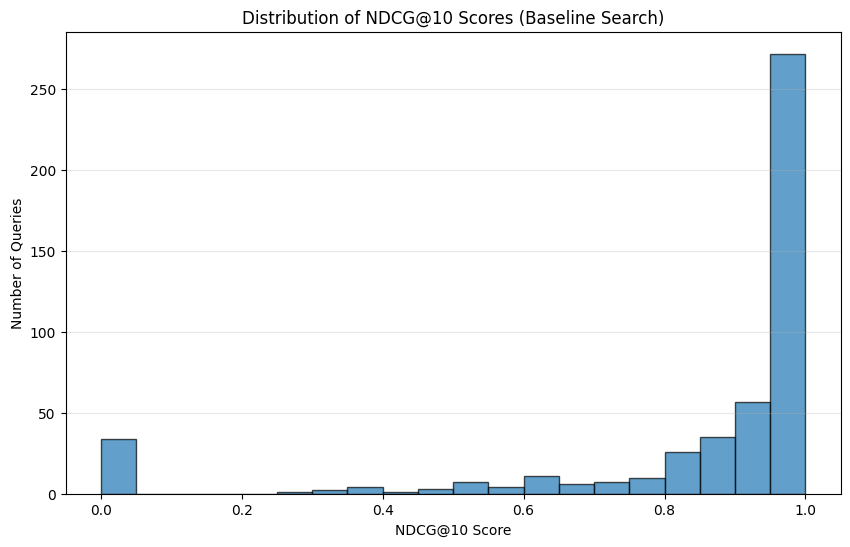

NDCG Score Statistics:
Mean: 0.8533
Median: 0.9764
Min: 0.0000
Max: 1.0000
Std Dev: 0.2701

Performance breakdown:
Perfect (NDCG = 1.0): 188 queries (39.2%)
Good (NDCG >= 0.5): 435 queries (90.6%)
Poor (NDCG < 0.5): 45 queries (9.4%)
Failed (NDCG = 0): 34 queries (7.1%)


In [35]:
# Task 5c: Analyze the distribution

import matplotlib.pyplot as plt

# Create histogram of NDCG scores
plt.figure(figsize=(10, 6))
plt.hist(baseline_results['ndcg'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('NDCG@10 Score')
plt.ylabel('Number of Queries')
plt.title('Distribution of NDCG@10 Scores (Baseline Search)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Summary statistics
print("NDCG Score Statistics:")
print(f"Mean: {baseline_results['ndcg'].mean():.4f}")
print(f"Median: {baseline_results['ndcg'].median():.4f}")
print(f"Min: {baseline_results['ndcg'].min():.4f}")
print(f"Max: {baseline_results['ndcg'].max():.4f}")
print(f"Std Dev: {baseline_results['ndcg'].std():.4f}")

# Percentage of queries by performance
print("\nPerformance breakdown:")
print(f"Perfect (NDCG = 1.0): {(baseline_results['ndcg'] == 1.0).sum()} queries ({(baseline_results['ndcg'] == 1.0).mean()*100:.1f}%)")
print(f"Good (NDCG >= 0.5): {(baseline_results['ndcg'] >= 0.5).sum()} queries ({(baseline_results['ndcg'] >= 0.5).mean()*100:.1f}%)")
print(f"Poor (NDCG < 0.5): {(baseline_results['ndcg'] < 0.5).sum()} queries ({(baseline_results['ndcg'] < 0.5).mean()*100:.1f}%)")
print(f"Failed (NDCG = 0): {(baseline_results['ndcg'] == 0).sum()} queries ({(baseline_results['ndcg'] == 0).mean()*100:.1f}%)")

---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [36]:
# Task 6a: Index product_class field

# Build indices for all three fields
product_name_index, product_name_lengths = build_index(
    products['product_name'].tolist(), 
    tokenize
)

product_desc_index, product_desc_lengths = build_index(
    products['product_description'].tolist(), 
    tokenize
)

product_class_index, product_class_lengths = build_index(
    products['product_class'].tolist(), 
    tokenize
)

print("Indices built for all fields:")
print(f"  - product_name: {len(product_name_index)} unique terms")
print(f"  - product_description: {len(product_desc_index)} unique terms")
print(f"  - product_class: {len(product_class_index)} unique terms")

# Create a three-field search function
def search_products_multifield(query: str, products_df: pd.DataFrame, k: int = 10) -> pd.DataFrame:
    """
    Search across name, description, and class fields.
    Combines scores using max (dismax approach).
    """
    # Get scores from each field
    name_scores = score_bm25(query, product_name_index, product_name_lengths, 
                            len(products_df), tokenize)
    desc_scores = score_bm25(query, product_desc_index, product_desc_lengths, 
                            len(products_df), tokenize)
    class_scores = score_bm25(query, product_class_index, product_class_lengths, 
                             len(products_df), tokenize)
    
    # Combine using max (dismax)
    combined_scores = np.maximum(np.maximum(name_scores, desc_scores), class_scores)
    
    # Get top k
    top_k_indices = np.argsort(combined_scores)[-k:][::-1]
    
    # Create results
    results = products_df.iloc[top_k_indices].copy()
    results['score'] = combined_scores[top_k_indices]
    
    # Filter zero scores
    results = results[results['score'] > 0]
    
    return results[['product_name', 'product_class', 'score']]

# Test it
print("\n" + "="*60)
print("Testing multi-field search on 'star wars rug'")
print("="*60)
results = search_products_multifield("star wars rug", products, k=5)
print(results)

Indices built for all fields:
  - product_name: 29617 unique terms
  - product_description: 38551 unique terms
  - product_class: 960 unique terms

Testing multi-field search on 'star wars rug'
                                            product_name  \
34916  star wars rule the galaxy rectangular pillow c...   
22734  “ star wars - darth vader ” autographed framed...   
36859                           star wars ep9 coffee mug   
28470           star wars dark side storage accent trunk   
21847       star wars tie fighter 10 light string lights   

                                    product_class      score  
34916            Licensed Products|Accent Pillows  21.864341  
22734                  Licensed Products|Wall Art  21.405317  
36859            Licensed Products|Mugs & Teacups  20.646758  
28470  Licensed Products|Toy Boxes and Organizers  20.559840  
21847          Holiday Lighting|Licensed Products  19.821561  


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [37]:
# Task 6b: Evaluate three-field search

# Evaluate the multi-field search
multifield_results = evaluate_queries(
    queries,
    products,
    labels,
    search_products_multifield,
    k=10,
    verbose=True
)

print("\nSample results:")
print(multifield_results.head(10))

# Compare to baseline
print("\n" + "="*60)
print("COMPARISON: Baseline vs Multi-Field")
print("="*60)
print(f"Baseline Mean NDCG@10:    {baseline_results['ndcg'].mean():.4f}")
print(f"Multi-Field Mean NDCG@10: {multifield_results['ndcg'].mean():.4f}")
print(f"Improvement:              {(multifield_results['ndcg'].mean() - baseline_results['ndcg'].mean()):.4f}")

Evaluated 480 queries
Mean NDCG@10: 0.8240

Sample results:
   query_id                      query      ndcg
0         0                salon chair  1.000000
1         1         smart coffee table  0.963167
2         2                   dinosaur  1.000000
3         3          turquoise pillows  0.757890
4         4  chair and a half recliner  1.000000
5         5          sofa with ottoman  0.940182
6         6        acrylic clear chair  1.000000
7         7           driftwood mirror  1.000000
8         8       home sweet home sign  1.000000
9         9      coffee table fire pit  1.000000

COMPARISON: Baseline vs Multi-Field
Baseline Mean NDCG@10:    0.8533
Multi-Field Mean NDCG@10: 0.8240
Improvement:              -0.0292


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [38]:
# Task 6c: Compare to baseline

# Merge results to compare
comparison = baseline_results.merge(
    multifield_results, 
    on=['query_id', 'query'], 
    suffixes=('_baseline', '_multifield')
)

# Calculate improvement
comparison['improvement'] = comparison['ndcg_multifield'] - comparison['ndcg_baseline']

# Queries that improved
improved = comparison[comparison['improvement'] > 0].sort_values('improvement', ascending=False)
print(f"Queries that IMPROVED: {len(improved)}")
print("\nTop 5 improvements:")
print(improved[['query', 'ndcg_baseline', 'ndcg_multifield', 'improvement']].head())

# Queries that degraded
degraded = comparison[comparison['improvement'] < 0].sort_values('improvement')
print(f"\nQueries that DEGRADED: {len(degraded)}")
print("\nTop 5 degradations:")
print(degraded[['query', 'ndcg_baseline', 'ndcg_multifield', 'improvement']].head())

# Queries unchanged
unchanged = comparison[comparison['improvement'] == 0]
print(f"\nQueries UNCHANGED: {len(unchanged)}")

# Analyze one improved query
if len(improved) > 0:
    sample = improved.iloc[0]
    print(f"\n{'='*60}")
    print(f"Example improved query: '{sample['query']}'")
    print(f"Baseline NDCG: {sample['ndcg_baseline']:.4f}")
    print(f"Multi-field NDCG: {sample['ndcg_multifield']:.4f}")
    print('='*60)

Queries that IMPROVED: 122

Top 5 improvements:
                              query  ndcg_baseline  ndcg_multifield  \
219        wisdom stone river 3-3/4            0.0         1.000000   
460  town & country living curtains            0.0         0.921787   
135   low profile loveseat recliner            0.0         0.905104   
167                        printers            0.0         0.888111   
252  high weight capacity bunk beds            0.0         0.776161   

     improvement  
219     1.000000  
460     0.921787  
135     0.905104  
167     0.888111  
252     0.776161  

Queries that DEGRADED: 245

Top 5 degradations:
                                                 query  ndcg_baseline  \
472                    pictures to hang over fireplace       1.000000   
133                             outdoor light fixtures       1.000000   
296                               circle cabinet pulls       0.946902   
31                               burnt orange curtains       1.000000 

---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [41]:
# Task 7a: Extract product type, theme, material, color, and other information from the query

from pydantic import BaseModel, Field
from typing import Optional

class QueryUnderstanding(BaseModel):
    """Structured output for query understanding."""
    product_type: Optional[str] = Field(None, description="The type of product (e.g., 'rug', 'table', 'sofa')")
    theme: Optional[str] = Field(None, description="Theme or style (e.g., 'star wars', 'modern', 'rustic')")
    material: Optional[str] = Field(None, description="Material (e.g., 'wooden', 'leather', 'metal')")
    color: Optional[str] = Field(None, description="Color (e.g., 'blue', 'red', 'black')")
    other_attributes: Optional[str] = Field(None, description="Any other relevant attributes")

def understand_query(query: str) -> QueryUnderstanding:
    """
    Use LLM to extract structured information from a search query.
    """
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": """You are a search query analyzer for an e-commerce furniture store.
Extract key attributes from user queries. Be concise and extract only what's clearly present.
If an attribute isn't mentioned, leave it as null."""
            },
            {
                "role": "user",
                "content": f"Extract product attributes from this query: '{query}'"
            }
        ],
        response_format=QueryUnderstanding,
        max_tokens=150
    )
    
    # Parse the response
    import json
    result = json.loads(response.choices[0].message.content)
    return QueryUnderstanding(**result)



In [42]:
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

print("Testing query understanding:\n")
for q in test_queries:
    understanding = understand_query(q)
    print(f"Query: '{q}'")
    print(f"  Product Type: {understanding.product_type}")
    print(f"  Theme: {understanding.theme}")
    print(f"  Material: {understanding.material}")
    print(f"  Color: {understanding.color}")
    print(f"  Other: {understanding.other_attributes}")
    print()

Testing query understanding:

Query: 'star wars rug'
  Product Type: rug
  Theme: star wars
  Material: None
  Color: None
  Other: None

Query: 'wooden coffee table'
  Product Type: table
  Theme: None
  Material: wooden
  Color: None
  Other: coffee

Query: 'blue leather sofa'
  Product Type: sofa
  Theme: None
  Material: leather
  Color: blue
  Other: None

Query: 'modern metal bookshelf'
  Product Type: bookshelf
  Theme: modern
  Material: metal
  Color: None
  Other: None



### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [45]:
# Task 7b: Create an LLM-enhanced search

def search_products_llm_enhanced(query: str, products_df: pd.DataFrame, k: int = 10) -> pd.DataFrame:
    """
    Search with LLM-based query understanding.
    Boosts products matching the extracted product_type.
    """
    # Get base multi-field scores
    name_scores = score_bm25(query, product_name_index, product_name_lengths, 
                            len(products_df), tokenize)
    desc_scores = score_bm25(query, product_desc_index, product_desc_lengths, 
                            len(products_df), tokenize)
    class_scores = score_bm25(query, product_class_index, product_class_lengths, 
                             len(products_df), tokenize)
    
    # Combine using max
    combined_scores = np.maximum(np.maximum(name_scores, desc_scores), class_scores)
    
    # Use LLM to understand query
    try:
        understanding = understand_query(query)
        
        # Boost products matching the product_type
        if understanding.product_type:
            boost_factor = 2.0  # Boost multiplier
            product_type_lower = understanding.product_type.lower()
            
            # Check which products match the product type
            for idx, row in products_df.iterrows():
                product_class_lower = str(row['product_class']).lower()
                if product_type_lower in product_class_lower:
                    combined_scores[idx] *= boost_factor
    
    except Exception as e:
        print(f"LLM query understanding failed: {e}")
        # Fall back to regular multi-field search
        pass
    
    # Get top k
    top_k_indices = np.argsort(combined_scores)[-k:][::-1]
    
    # Create results
    results = products_df.iloc[top_k_indices].copy()
    results['score'] = combined_scores[top_k_indices]
    
    # Filter zero scores
    results = results[results['score'] > 0]
    
    return results[['product_name', 'product_class', 'score']]

# Test it
print("Testing LLM-enhanced search:\n")
test_query = "star wars rug"
print(f"Query: '{test_query}'")
print("="*60)

print("\nMulti-field results:")
multifield_res = search_products_multifield(test_query, products, k=5)
print(multifield_res)

print("\nLLM-enhanced results:")
llm_res = search_products_llm_enhanced(test_query, products, k=5)
print(llm_res)

Testing LLM-enhanced search:

Query: 'star wars rug'

Multi-field results:
                                            product_name  \
34916  star wars rule the galaxy rectangular pillow c...   
22734  “ star wars - darth vader ” autographed framed...   
36859                           star wars ep9 coffee mug   
28470           star wars dark side storage accent trunk   
21847       star wars tie fighter 10 light string lights   

                                    product_class      score  
34916            Licensed Products|Accent Pillows  21.864341  
22734                  Licensed Products|Wall Art  21.405317  
36859            Licensed Products|Mugs & Teacups  20.646758  
28470  Licensed Products|Toy Boxes and Organizers  20.559840  
21847          Holiday Lighting|Licensed Products  19.821561  

LLM-enhanced results:
                                            product_name  \
34916  star wars rule the galaxy rectangular pillow c...   
22734  “ star wars - darth vader ” autograp

In [46]:
# Evaluate LLM-enhanced search on all queries

print("Evaluating LLM-enhanced search (this may take a few minutes due to API calls)...\n")

llm_enhanced_results = evaluate_queries(
    queries,
    products,
    labels,
    search_products_llm_enhanced,
    k=10,
    verbose=True
)

# Compare all three approaches
print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)
print(f"Baseline (name only):     {baseline_results['ndcg'].mean():.4f}")
print(f"Multi-Field:              {multifield_results['ndcg'].mean():.4f}")
print(f"LLM-Enhanced:             {llm_enhanced_results['ndcg'].mean():.4f}")
print("\nImprovements:")
print(f"Multi-Field vs Baseline:  {(multifield_results['ndcg'].mean() - baseline_results['ndcg'].mean()):.4f}")
print(f"LLM vs Multi-Field:       {(llm_enhanced_results['ndcg'].mean() - multifield_results['ndcg'].mean()):.4f}")
print(f"LLM vs Baseline:          {(llm_enhanced_results['ndcg'].mean() - baseline_results['ndcg'].mean()):.4f}")

Evaluating LLM-enhanced search (this may take a few minutes due to API calls)...

Evaluated 480 queries
Mean NDCG@10: 0.8340

FINAL COMPARISON
Baseline (name only):     0.8533
Multi-Field:              0.8240
LLM-Enhanced:             0.8340

Improvements:
Multi-Field vs Baseline:  -0.0292
LLM vs Multi-Field:       0.0100
LLM vs Baseline:          -0.0192


---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
